<img src="images/HeadingSlideSmall.png" width="400">



# Steps In this Demo


<img src="images/DataLifecycle.png" align="left" width="200" style="margin-right: 30px;" />
<img src="attachment:Screen%20Shot%202018-04-07%20at%207.55.44%20am.png" align="left" width="200" style="margin-right: 30px;"/>

1. <font size=4>[Preparing The Data](#Preparing-The-Data)</font>
2. <font size=4>[Building the Model](#Building-the-model)</font>
3. <font size=4>[Training on Amazon SageMaker](#Training-on-Amazon-SageMaker)</font>
4. <font size=4>[Deploy Using Amazon SageMaker](#Deploy-Using-Amazon-SageMaker)</font>
5. <font size=4>[Perform Inference](#Perform-Inference)</font>


<br><br><br><br><br>


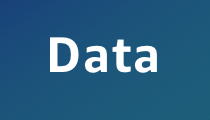

# Preparing The Data
***

We will be using our own custom image classification dataset prepared using SageMaker GroundTruth. The image set has only 18 images
* 6 images of grapes
* 6 images of oranges
* 6 images of tomatoes

Let's have a quick look!

### 1.a - Configuring The S3 Bucket


In [15]:
bucket='djenny-sagemaker-sydney' #'<<bucket-name>>' # customize to your bucket
prefix = 'UNSW-Demo-GT-wb'

### 1.b - Downloading The Image Data Set

* Download the dataset (RecordIO data format)

In [2]:
gt_images_to_label = "unsw/images_to_label2"
s3_gt_images = 's3://{}/{}/'.format(bucket, gt_images_to_label)

# Download the images used by the Ground Truth labelling job
# Note: We wouldn't normally download all our images to our notebook, 
#       but since we only have such a small number of images in this dataset, we will get them all
!aws s3 cp $s3_gt_images gt_images --recursive --exclude "*" --include "*.jpg" --include "*.jpeg"

download: s3://djenny-sagemaker-sydney/unsw/images_to_label2/grapes10.jpg to gt_images/grapes10.jpg
download: s3://djenny-sagemaker-sydney/unsw/images_to_label2/grapes11.jpg to gt_images/grapes11.jpg
download: s3://djenny-sagemaker-sydney/unsw/images_to_label2/grapes1.jpg to gt_images/grapes1.jpg
download: s3://djenny-sagemaker-sydney/unsw/images_to_label2/grapes13.jpg to gt_images/grapes13.jpg
download: s3://djenny-sagemaker-sydney/unsw/images_to_label2/grapes20.jpg to gt_images/grapes20.jpg
download: s3://djenny-sagemaker-sydney/unsw/images_to_label2/grapes14.jpg to gt_images/grapes14.jpg
download: s3://djenny-sagemaker-sydney/unsw/images_to_label2/grapes15.jpg to gt_images/grapes15.jpg
download: s3://djenny-sagemaker-sydney/unsw/images_to_label2/grapes2.jpg to gt_images/grapes2.jpg
download: s3://djenny-sagemaker-sydney/unsw/images_to_label2/grapes16.jpg to gt_images/grapes16.jpg
download: s3://djenny-sagemaker-sydney/unsw/images_to_label2/grapes12.jpg to gt_images/grapes12.jpg
down

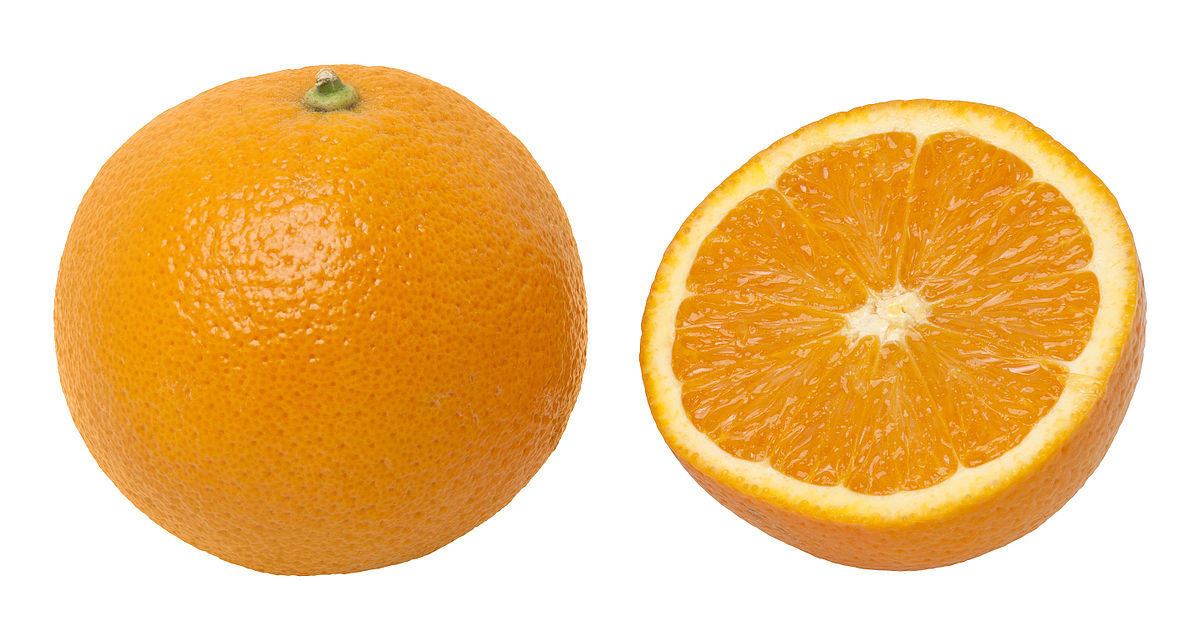

In [3]:
file_name = 'gt_images/orange2.jpg'
#file_name = 'gt_images/grapes2.jpg'
#file_name = 'gt_images/tomato2.jpg'

from IPython.display import Image
Image(file_name, width=300)  

### 1.c SageMaker Ground Truth output manifest

SageMaker Ground Truth was used to label these images and hence create our training dataset.
The key component of this output is the Ground Truth output.manifest file

Let's download it and take a look

In [4]:
#gt_output_dir = "unsw/groundtruth_output/FruitTypes/manifests/output"
gt_output_dir = "unsw/fruit_white_bg/fruit-white-bg/manifests/output"
s3_gt_output_dir = 's3://{}/{}/'.format(bucket, gt_output_dir)

# Download the images used by the Ground Truth labelling job
# Note: We wouldn't normally download all our images to our notebook, 
#       but since we only have such a small number of images in this dataset, we will get them all
!aws s3 cp $s3_gt_output_dir gt_output_manifest --recursive --exclude "*" --include "*.manifest"

download: s3://djenny-sagemaker-sydney/unsw/fruit_white_bg/fruit-white-bg/manifests/output/output.manifest to gt_output_manifest/output.manifest


In [56]:
!head -1 gt_output_manifest/output.manifest

{"source-ref":"s3://djenny-sagemaker-sydney/unsw/images_to_label2/grapes1.jpg","fruit-type":0,"fruit-type-metadata":{"confidence":0.66,"job-name":"labeling-job/fruit-white-bg","class-name":"grapes","human-annotated":"yes","creation-date":"2019-11-18T06:43:39.311306","type":"groundtruth/image-classification"}}


### 1.d Prepare training and validation manifest files

Shuffle and then split output.manifest into train.manifest and validation.manifest
Use a 80/20 split

In [9]:
import numpy as np
import json
with open('gt_output_manifest/output.manifest', 'r') as f:
    output = [json.loads(line) for line in f.readlines()]

# Shuffle output in place.
np.random.shuffle(output)
    
dataset_size = len(output)
train_test_split_index = round(dataset_size*0.8)

train_data = output[:train_test_split_index]
validation_data = output[train_test_split_index:]

num_training_samples = 0
with open('train.manifest', 'w') as f:
    for line in train_data:
        f.write(json.dumps(line))
        f.write('\n')
        num_training_samples += 1
    
with open('validation.manifest', 'w') as f:
    for line in validation_data:
        f.write(json.dumps(line))
        f.write('\n')

Check how many images are in our training dataset - we need to provide this as a hyperparameter to our training job

In [10]:
train_img_count_string = !cat train.manifest | wc -l
train_img_count_int = int(train_img_count_string[0])
print(train_img_count_int)

!wc -l validation.manifest


48
12 validation.manifest


Upload train.manifest and validation.manifest to S3 in preparation for training job

In [11]:
import boto3
s3 = boto3.client('s3')

In [12]:
s3.upload_file('train.manifest',bucket, gt_output_dir + '/train.manifest')
s3.upload_file('validation.manifest',bucket, gt_output_dir + '/validation.manifest')


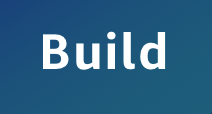

# 2. Building the Model
***



### 2.a - Select our algorithm

We will use Amazon SageMaker's Built Image Classification Algorithm

In [13]:
import sagemaker
sess = sagemaker.Session()

from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri

role = get_execution_role()

training_image = get_image_uri(sess.boto_region_name, 'image-classification')
print(role)
print(training_image)

arn:aws:iam::493843837665:role/service-role/AmazonSageMaker-ExecutionRole-20191009T151701
544295431143.dkr.ecr.ap-southeast-2.amazonaws.com/image-classification:1


### 2.b Choose our hyperparameters

* Using the pre-trained option (Transfer Learning)
* Take advantage of the algorithms built-in image augmentation
* Define the algorithm hyperparameters

In [20]:
# The algorithm supports multiple network depth (number of layers). They are 18, 34, 50, 101, 152 and 200
# For this training, we will use 18 layers
num_layers = 18 # 18
# we need to specify the input image shape for the training data
image_shape = "3,224,224"
# we also need to specify the number of training samples in the training set
num_training_samples = train_img_count_int
# specify the number of output classes
num_classes = 3
# batch size for training
mini_batch_size =  8
# number of epochs
epochs = 200
# learning rate
learning_rate = 0.01
top_k=2
# Since we are using transfer learning, we set use_pretrained_model to 1 so that weights can be 
# initialized with pre-trained weights
use_pretrained_model = 1
# Use image augmentation to increase our training dataset
augmentation_type = "crop"


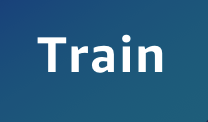

# 3. Training on Amazon SageMaker
***

### 3.a - First Defining The Training Configurations
* Configure the output location

In [16]:
s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)

* Configure the training set up

In [17]:
ic_model = sagemaker.estimator.Estimator(training_image,
                                        role,
                                        train_instance_count=1,
                                        train_instance_type='ml.p2.8xlarge',
                                        train_volume_size = 50,
                                        train_max_run = 360000,
                                        input_mode = 'Pipe',
                                        output_path=s3_output_location,
                                        sagemaker_session=sess)

* Setting the hyperparameters

In [18]:
ic_model.set_hyperparameters(num_layers=num_layers,
                            image_shape=image_shape,
                            num_training_samples=num_training_samples,
                            num_classes=num_classes,
                            mini_batch_size=mini_batch_size,
                            epochs=epochs,
                            learning_rate=learning_rate,
                            top_k=top_k,
                            use_pretrained_model=use_pretrained_model,
                            augmentation_type=augmentation_type)

* Training and validation data locations

Note: Tips I used for setting s3_input parameters for a job using Ground Truth output:<br>
[Example using SageMaker low-level boto3 library](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/ground_truth_labeling_jobs/from_unlabeled_data_to_deployed_machine_learning_model_ground_truth_demo_image_classification/from_unlabeled_data_to_deployed_machine_learning_model_ground_truth_demo_image_classification.ipynb "Jupyter Notebook")<br>
[Code samples using SageMaker high-level library](https://github.com/aws/sagemaker-python-sdk/blob/master/tests/unit/test_session.py "Github repo")

In [19]:
train_data = sagemaker.session.s3_input("s3://djenny-sagemaker-sydney/unsw/fruit_white_bg/fruit-white-bg/manifests/output/train.manifest",
                                        distribution='FullyReplicated',
                                        content_type='application/x-recordio',
                                        s3_data_type='AugmentedManifestFile',
                                        record_wrapping='RecordIO',
                                        attribute_names=['source-ref','fruit-type']) 

validation_data = sagemaker.session.s3_input("s3://djenny-sagemaker-sydney/unsw/fruit_white_bg/fruit-white-bg/manifests/output/validation.manifest",
                                        distribution='FullyReplicated',
                                        content_type='application/x-recordio',
                                        s3_data_type='AugmentedManifestFile',
                                        record_wrapping='RecordIO',
                                        attribute_names=['source-ref','fruit-type']) 

data_channels = {'train': train_data, 'validation': validation_data}

### 3.b - Submit the Training Job

In [21]:
%%time
ic_model.fit(inputs=data_channels, logs=True)

2019-11-18 06:54:00 Starting - Starting the training job...
2019-11-18 06:54:03 Starting - Launching requested ML instances.........
2019-11-18 06:55:33 Starting - Preparing the instances for training......
2019-11-18 06:56:56 Downloading - Downloading input data
2019-11-18 06:56:56 Training - Downloading the training image......
2019-11-18 06:57:59 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
[11/18/2019 06:58:03 INFO 140470717548352] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/image_classification/default-input.json: {u'beta_1': 0.9, u'gamma': 0.9, u'beta_2': 0.999, u'optimizer': u'sgd', u'use_pretrained_model': 0, u'eps': 1e-08, u'epochs': 30, u'lr_scheduler_factor': 0.1, u'num_layers': 152, u'image_shape': u'3,224,224', u'precision_dtype': u'float32', u'mini_batch_size': 32, u'weight_decay': 0.0001, u'learning_rate': 0.1, u'momentum': 0}
[11/18/2019 06:58:03 INFO 140470717548352] 

[11/18/2019 06:58:36 INFO 140470717548352] Epoch[14] Train-accuracy=0.312500
[11/18/2019 06:58:36 INFO 140470717548352] Epoch[14] Train-top_k_accuracy_2=0.729167
[11/18/2019 06:58:36 INFO 140470717548352] Epoch[14] Time cost=0.327
[11/18/2019 06:58:36 INFO 140470717548352] Epoch[14] Validation-accuracy=0.312500
[11/18/2019 06:58:37 INFO 140470717548352] Epoch[15] Train-accuracy=0.333333
[11/18/2019 06:58:37 INFO 140470717548352] Epoch[15] Train-top_k_accuracy_2=0.708333
[11/18/2019 06:58:37 INFO 140470717548352] Epoch[15] Time cost=0.341
[11/18/2019 06:58:37 INFO 140470717548352] Epoch[15] Validation-accuracy=0.312500
[11/18/2019 06:58:38 INFO 140470717548352] Epoch[16] Train-accuracy=0.458333
[11/18/2019 06:58:38 INFO 140470717548352] Epoch[16] Train-top_k_accuracy_2=0.750000
[11/18/2019 06:58:38 INFO 140470717548352] Epoch[16] Time cost=0.316
[11/18/2019 06:58:38 INFO 140470717548352] Epoch[16] Validation-accuracy=0.312500
[11/18/2019 06:58:39 INFO 140470717548352] Epoch[17] Train-ac

[11/18/2019 06:59:01 INFO 140470717548352] Epoch[46] Train-accuracy=0.708333
[11/18/2019 06:59:01 INFO 140470717548352] Epoch[46] Train-top_k_accuracy_2=0.916667
[11/18/2019 06:59:01 INFO 140470717548352] Epoch[46] Time cost=0.314
[11/18/2019 06:59:02 INFO 140470717548352] Epoch[46] Validation-accuracy=0.312500
[11/18/2019 06:59:02 INFO 140470717548352] Epoch[47] Train-accuracy=0.541667
[11/18/2019 06:59:02 INFO 140470717548352] Epoch[47] Train-top_k_accuracy_2=0.895833
[11/18/2019 06:59:02 INFO 140470717548352] Epoch[47] Time cost=0.308
[11/18/2019 06:59:02 INFO 140470717548352] Epoch[47] Validation-accuracy=0.312500
[11/18/2019 06:59:03 INFO 140470717548352] Epoch[48] Train-accuracy=0.729167
[11/18/2019 06:59:03 INFO 140470717548352] Epoch[48] Train-top_k_accuracy_2=0.875000
[11/18/2019 06:59:03 INFO 140470717548352] Epoch[48] Time cost=0.314
[11/18/2019 06:59:03 INFO 140470717548352] Epoch[48] Validation-accuracy=0.312500
[11/18/2019 06:59:04 INFO 140470717548352] Epoch[49] Train-ac

[11/18/2019 06:59:27 INFO 140470717548352] Epoch[78] Train-accuracy=0.812500
[11/18/2019 06:59:27 INFO 140470717548352] Epoch[78] Train-top_k_accuracy_2=0.958333
[11/18/2019 06:59:27 INFO 140470717548352] Epoch[78] Time cost=0.308
[11/18/2019 06:59:27 INFO 140470717548352] Epoch[78] Validation-accuracy=0.000000
[11/18/2019 06:59:27 INFO 140470717548352] Epoch[79] Train-accuracy=0.895833
[11/18/2019 06:59:27 INFO 140470717548352] Epoch[79] Train-top_k_accuracy_2=0.979167
[11/18/2019 06:59:27 INFO 140470717548352] Epoch[79] Time cost=0.313
[11/18/2019 06:59:28 INFO 140470717548352] Epoch[79] Validation-accuracy=0.000000
[11/18/2019 06:59:28 INFO 140470717548352] Epoch[80] Train-accuracy=0.833333
[11/18/2019 06:59:28 INFO 140470717548352] Epoch[80] Train-top_k_accuracy_2=0.979167
[11/18/2019 06:59:28 INFO 140470717548352] Epoch[80] Time cost=0.307
[11/18/2019 06:59:28 INFO 140470717548352] Epoch[80] Validation-accuracy=0.000000
[11/18/2019 06:59:29 INFO 140470717548352] Epoch[81] Train-ac


<img src="attachment:Screen%20Shot%202018-04-06%20at%205.21.16%20pm.png" align="left">


# 4. Deploy Using Amazon SageMaker

***


Model = Inference Code + Model Artifacts

In [22]:
image_classifier = ic_model.deploy(initial_instance_count = 2,  # HA!
                                 instance_type = 'ml.t2.medium')

--------------------------------------------------------------------------------------------------------------------------------------------------!

# 5. Perform Inference
***

### 5.a - Download The Test Image

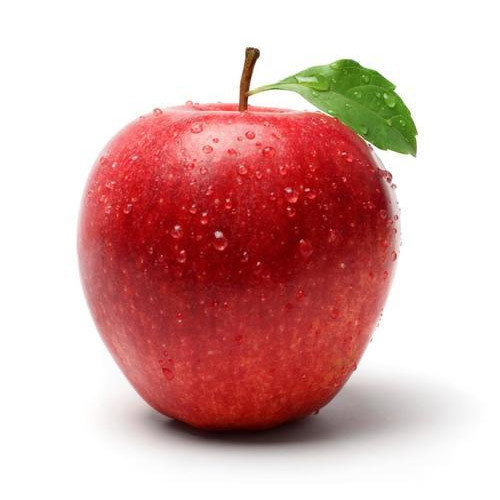

In [53]:
file_name = 'test_images/test_grapes.jpg'
file_name = 'test_images/test_tomato.jpg'
file_name = 'test_images/test_orange.jpg'
file_name = 'test_images/test_apple.jpg'

# test image
from IPython.display import Image
Image(file_name, width=300)  

### 5.b - Invoke the Endpoint

In [54]:
import json
import numpy as np

with open(file_name, 'rb') as f:
    payload = f.read()
    payload = bytearray(payload)

image_classifier.content_type = 'image/jpeg'

result = image_classifier.predict(payload)

classification = json.loads(result)
index = np.argmax(classification)

image_categories = ['grapes', 'orange', 'tomato']
print("Result: label - " + image_categories[index] + ", probability - " + str(classification[index]))


Result: label - tomato, probability - 0.6994302868843079


#### Clean up


In [ ]:
#sagemaker.Session().delete_endpoint(image_classifier.endpoint)